In [17]:
#Check Version
import statsmodels._version
if statsmodels._version.get_versions()['version'] != '0.11.1':
  !pip install --upgrade statsmodels

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

!cd "/content/drive/My Drive/Colab Notebooks/Time_Series_Projects/Data"

df1 = pd.read_csv('airline_passengers.csv',index_col='Month',parse_dates=True)
df1.index.freq = 'MS' # Month Start

df2 = pd.read_csv('DailyTotalFemaleBirths.csv',index_col='Date',parse_dates=True)
df2.index.freq = 'D' # Month Start


## Testing for Stationarity

## Augmented Dickey-Fuller Test
To determine whether a series is stationary we can use the <a href='https://en.wikipedia.org/wiki/Augmented_Dickey-Fuller_test'>augmented Dickey-Fuller Test</a>. In this test the null hypothesis states that $\phi = 1$ (this is also called a unit test). The test returns several statistics we'll see in a moment. Our focus is on the p-value. A small p-value ($p<0.05$) indicates strong evidence against the null hypothesis.

To demonstrate, we'll use a dataset we know is <em>not</em> stationary, the airline_passenger dataset. First, let's plot the data along with a 12-month rolling mean and standard deviation:

Text(0.5, 1.0, 'Airline Passengers')

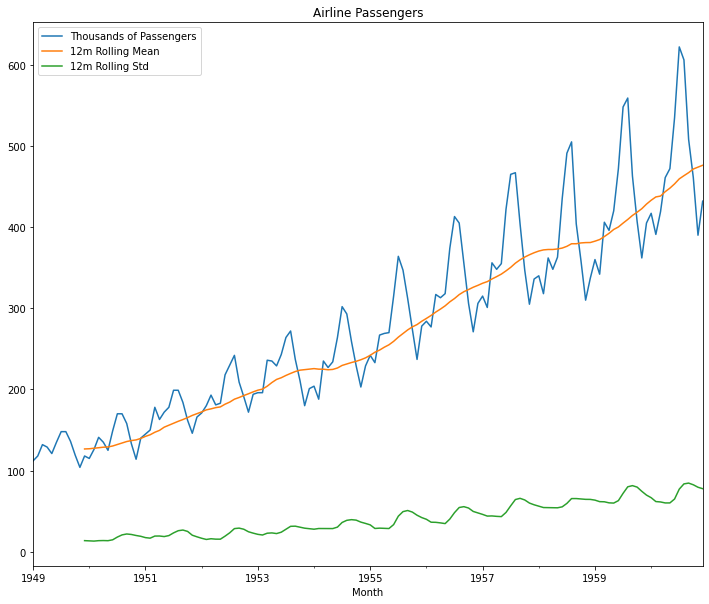

In [47]:
df1['12m Rolling Mean'] = df1.rolling(12).mean()
df1['12m Rolling Std'] = df1.rolling(12).std()
df1.plot(figsize=(12,10))
plt.title('Airline Passengers')

In [49]:
#help(adfuller);

### Function for running the augmented Dickey-Fuller test
Since we'll use it frequently in the upcoming forecasts, let's define a function we can copy into future notebooks for running the augmented Dickey-Fuller test. Remember that we'll still have to import <tt>adfuller</tt> at the top of our notebook.

In [63]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    print('\nResult:')
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [64]:
adf_test(df1['Thousands of Passengers'])

Augmented Dickey-Fuller Test: 
ADF test statistic        0.815369
p-value                   0.991880
# lags used              13.000000
# observations          130.000000
critical value (1%)      -3.481682
critical value (5%)      -2.884042
critical value (10%)     -2.578770

Result:
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


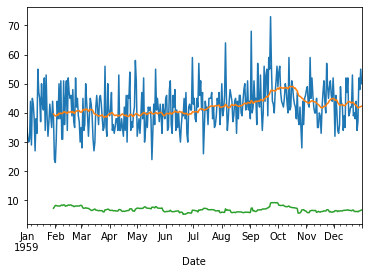

In [103]:
df2['Births'].plot()
df2['Births'].rolling(window=30).mean().plot()
df2['Births'].rolling(window=30).std().plot();



In [66]:
adf_test(df2['Births'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -4.808291
p-value                   0.000052
# lags used               6.000000
# observations          358.000000
critical value (1%)      -3.448749
critical value (5%)      -2.869647
critical value (10%)     -2.571089

Result:
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


# Granger Causality Tests
The <a href='https://en.wikipedia.org/wiki/Granger_causality'>Granger causality test</a> is a a hypothesis test to determine if one time series is useful in forecasting another. While it is fairly easy to measure correlations between series - when one goes up the other goes up, and vice versa - it's another thing to observe changes in one series correlated to changes in another after a consistent amount of time. This <em>may</em> indicate the presence of causality, that changes in the first series influenced the behavior of the second. However, it may also be that both series are affected by some third factor, just at different rates. Still, it can be useful if changes in one series can predict upcoming changes in another, whether there is causality or not. In this case we say that one series "Granger-causes" another.

In the case of two series, $y$ and $x$, the null hypothesis is that lagged values of $x$ do <em>not</em> explain variations in $y$.<br>
In other words, it assumes that $x_t$ doesn’t Granger-cause $y_t$.

The stattools <tt><strong>grangercausalitytests</strong></tt> function offers four tests for granger non-causality of 2 timeseries

For this example we'll use the samples.csv file, where columns 'a' and 'd' are stationary datasets.

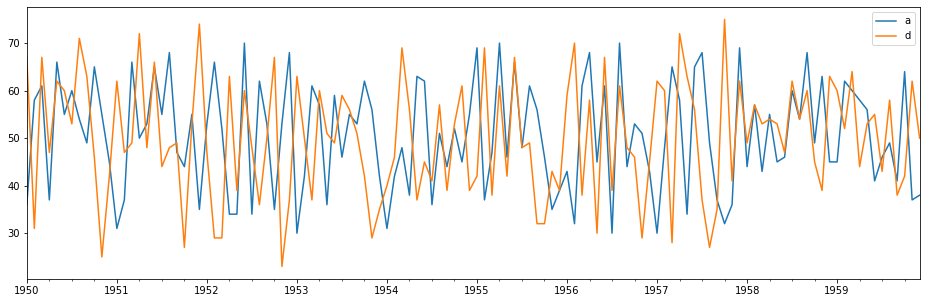

In [67]:
df3 = pd.read_csv('../Data/samples.csv',index_col=0,parse_dates=True)
df3.index.freq = 'MS'
df3[['a','d']].plot(figsize=(16,5));

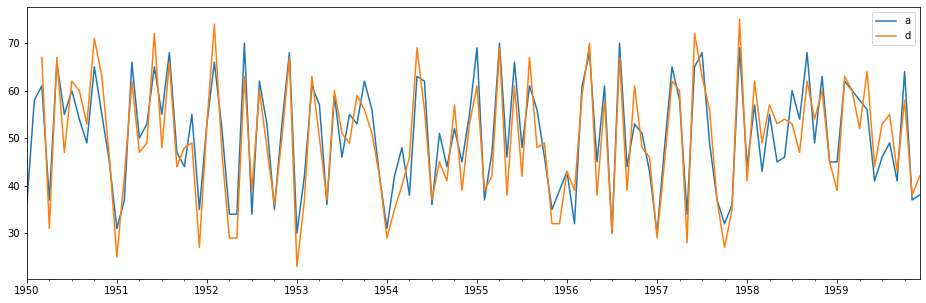

In [93]:
df3['a'].plot(figsize=(16,5),legend=True)
df3['d'].shift(2).plot(legend=True);

In [84]:
from statsmodels.tsa.stattools import grangercausalitytests

If p-value is small (<5%) then there is a relationship between the series

In [91]:
grangercausalitytests(df3[['a','d']],maxlag=3);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7051  , p=0.1942  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=1.7492  , p=0.1860  , df=1
likelihood ratio test: chi2=1.7365  , p=0.1876  , df=1
parameter F test:         F=1.7051  , p=0.1942  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=286.0339, p=0.0000  , df_denom=113, df_num=2
ssr based chi2 test:   chi2=597.3806, p=0.0000  , df=2
likelihood ratio test: chi2=212.6514, p=0.0000  , df=2
parameter F test:         F=286.0339, p=0.0000  , df_denom=113, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=188.7446, p=0.0000  , df_denom=110, df_num=3
ssr based chi2 test:   chi2=602.2669, p=0.0000  , df=3
likelihood ratio test: chi2=212.4789, p=0.0000  , df=3
parameter F test:         F=188.7446, p=0.0000  , df_denom=110, df_num=3


In [94]:
grangercausalitytests(df3[['a','b']],maxlag=3); #With no Causality


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8657  , p=0.1746  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=1.9140  , p=0.1665  , df=1
likelihood ratio test: chi2=1.8988  , p=0.1682  , df=1
parameter F test:         F=1.8657  , p=0.1746  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9723  , p=0.1439  , df_denom=113, df_num=2
ssr based chi2 test:   chi2=4.1192  , p=0.1275  , df=2
likelihood ratio test: chi2=4.0489  , p=0.1321  , df=2
parameter F test:         F=1.9723  , p=0.1439  , df_denom=113, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1777  , p=0.3216  , df_denom=110, df_num=3
ssr based chi2 test:   chi2=3.7580  , p=0.2888  , df=3
likelihood ratio test: chi2=3.6989  , p=0.2959  , df=3
parameter F test:         F=1.1777  , p=0.3216  , df_denom=110, df_num=3


# Evaluating forecast accuracy
Two calculations related to linear regression are <a href='https://en.wikipedia.org/wiki/Mean_squared_error'><strong>mean squared error</strong></a> (MSE) and <a href='https://en.wikipedia.org/wiki/Root-mean-square_deviation'><strong>root mean squared error</strong></a> (RMSE)

The formula for the mean squared error is<br><br>
&nbsp;&nbsp;&nbsp;&nbsp;$MSE = {\frac 1 L} \sum\limits_{l=1}^L (y_{T+l} - \hat y_{T+l})^2$<br><br>
where $T$ is the last observation period and $l$ is the lag point up to $L$ number of test observations.

The formula for the root mean squared error is<br><br>
&nbsp;&nbsp;&nbsp;&nbsp;$RMSE = \sqrt{MSE} = \sqrt{{\frac 1 L} \sum\limits_{l=1}^L (y_{T+l} - \hat y_{T+l})^2}$<br><br>

The advantage of the RMSE is that it is expressed in the same units as the data.<br><br>

A method similar to the RMSE is the <a href='https://en.wikipedia.org/wiki/Mean_absolute_error'><strong>mean absolute error</strong></a> (MAE) which is the mean of the magnitudes of the error, given as<br><br>

&nbsp;&nbsp;&nbsp;&nbsp;$MAE = {\frac 1 L} \sum\limits_{l=1}^L \mid{y_{T+l}} - \hat y_{T+l}\mid$<br><br>

A forecast method that minimizes the MAE will lead to forecasts of the median, while minimizing the RMSE will lead to forecasts of the mean.

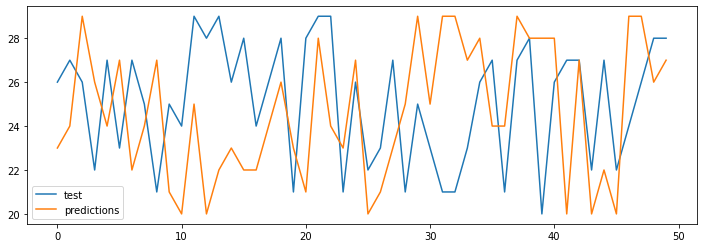

In [106]:
import numpy as np
import pandas as pd
%matplotlib inline
np.random.seed(42)
df = pd.DataFrame(np.random.randint(20,30,(50,2)),columns=['test','predictions'])
df.plot(figsize=(12,4));

In [108]:
#from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.tools.eval_measures import mse, rmse, meanabs

In [111]:
rmse(df['test'],df['predictions'])

4.125530268947253

In [112]:
df = pd.read_csv('airline_passengers.csv',index_col='Month',parse_dates=True)
df.index.freq = 'MS'

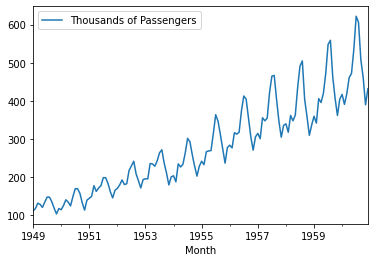

In [113]:
df.plot()

In [114]:
from statsmodels.graphics.tsaplots import month_plot,quarter_plot

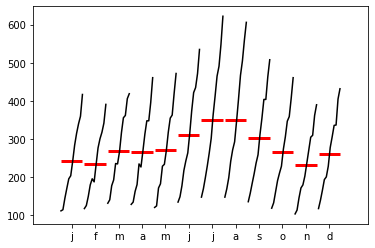

In [116]:
month_plot(df['Thousands of Passengers']);

In [117]:
dfq = df['Thousands of Passengers'].resample(rule='Q').mean()

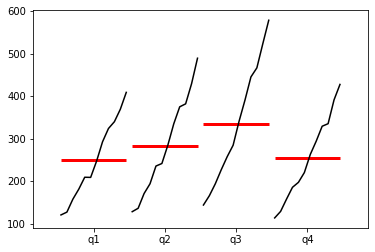

In [120]:
quarter_plot(dfq);